In [1]:
# ============================================================
# F1 Circuit Region Classification
# ============================================================

# Cell 1: Setup & Data Loading
# -----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Upload your file in Colab first:
from google.colab import files
uploaded = files.upload()  # Upload circuits.csv when prompted

df = pd.read_csv('circuits.csv')
print(f"Shape: {df.shape}")
df.head()

Saving circuits.csv to circuits.csv
Shape: (77, 9)


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [2]:
# Cell 2: Feature Engineering & Target Creation
# -----------------------------------------------------------

region_map = {
    'UK':'Europe','Spain':'Europe','Italy':'Europe','Germany':'Europe',
    'France':'Europe','Monaco':'Europe','Belgium':'Europe','Hungary':'Europe',
    'Turkey':'Europe','Netherlands':'Europe','Austria':'Europe',
    'Portugal':'Europe','Sweden':'Europe','Switzerland':'Europe',
    'Azerbaijan':'Europe','Russia':'Europe',
    'USA':'Americas','Canada':'Americas','Brazil':'Americas',
    'Argentina':'Americas','Mexico':'Americas','United States':'Americas',
    'Australia':'Asia_Oceania','Malaysia':'Asia_Oceania',
    'Bahrain':'Asia_Oceania','Japan':'Asia_Oceania','China':'Asia_Oceania',
    'Singapore':'Asia_Oceania','UAE':'Asia_Oceania','India':'Asia_Oceania',
    'Korea':'Asia_Oceania','Saudi Arabia':'Asia_Oceania','Qatar':'Asia_Oceania',
    'South Africa':'Africa','Morocco':'Africa'
}

df['region'] = df['country'].map(region_map).fillna('Other')

# Keep only regions with enough samples
valid = df['region'].value_counts()
valid = valid[valid >= 5].index
df = df[df['region'].isin(valid)].copy()

# Features
df['name_length'] = df['name'].apply(len)
df['abs_lat'] = df['lat'].abs()

X = df[['lat', 'lng', 'alt', 'name_length', 'abs_lat']].values
le = LabelEncoder()
y = le.fit_transform(df['region'])

print(f"Samples: {len(y)}")
print(f"Classes: {dict(zip(le.classes_, np.bincount(y)))}")

Samples: 74
Classes: {'Americas': np.int64(19), 'Asia_Oceania': np.int64(14), 'Europe': np.int64(41)}


Original features: 5
PCA features: 5
Variance explained: [0.4173 0.2626 0.1472 0.1049 0.0681]
Total variance: 1.0000


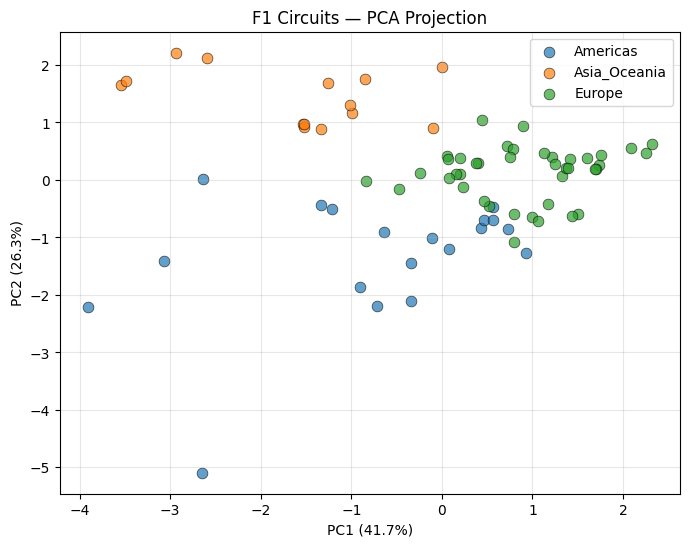

In [11]:
# Cell 3: Scaling + PCA
# -----------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Keep 95% variance automatically
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA features: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.round(4)}")
print(f"Total variance: {sum(pca.explained_variance_ratio_):.4f}")

# 2D visualization
plt.figure(figsize=(8, 6))
for i, name in enumerate(le.classes_):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=name, alpha=0.7, s=60, edgecolors='k', linewidth=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('F1 Circuits — PCA Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Cell 4: Train/Test Split + Model Definitions
# -----------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    'KNN (K=3)':      KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)':      KNeighborsClassifier(n_neighbors=5),
    'KNN (K=7)':      KNeighborsClassifier(n_neighbors=7),
    'SVM Linear':     SVC(kernel='linear', random_state=42),
    'SVM Poly':       SVC(kernel='poly', degree=3, random_state=42),
    'Random Forest':  RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree':  DecisionTreeClassifier(max_depth=5, random_state=42),
}

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 55 | Test: 19


In [15]:
# Cell 5: Cross-Validation + Test Evaluation
# -----------------------------------------------------------

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print(f"{'Model':<18} {'CV Mean':>8} {'CV Std':>8} {'Test':>8}")
print("-" * 45)

for name, model in models.items():
    cv = cross_val_score(model, X_pca, y, cv=skf, scoring='accuracy')
    model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    results[name] = {'cv': cv, 'test': test_acc}
    print(f"{name:<18} {cv.mean():>8.4f} {cv.std():>8.4f} {test_acc:>8.4f}")

Model               CV Mean   CV Std     Test
---------------------------------------------
KNN (K=3)            0.9867   0.0267   1.0000
KNN (K=5)            0.9733   0.0327   0.8947
KNN (K=7)            0.9333   0.0422   0.8421
SVM Linear           1.0000   0.0000   1.0000
SVM Poly             0.8790   0.0771   0.8947
Random Forest        0.9057   0.0319   1.0000
Decision Tree        0.8524   0.0972   0.8947


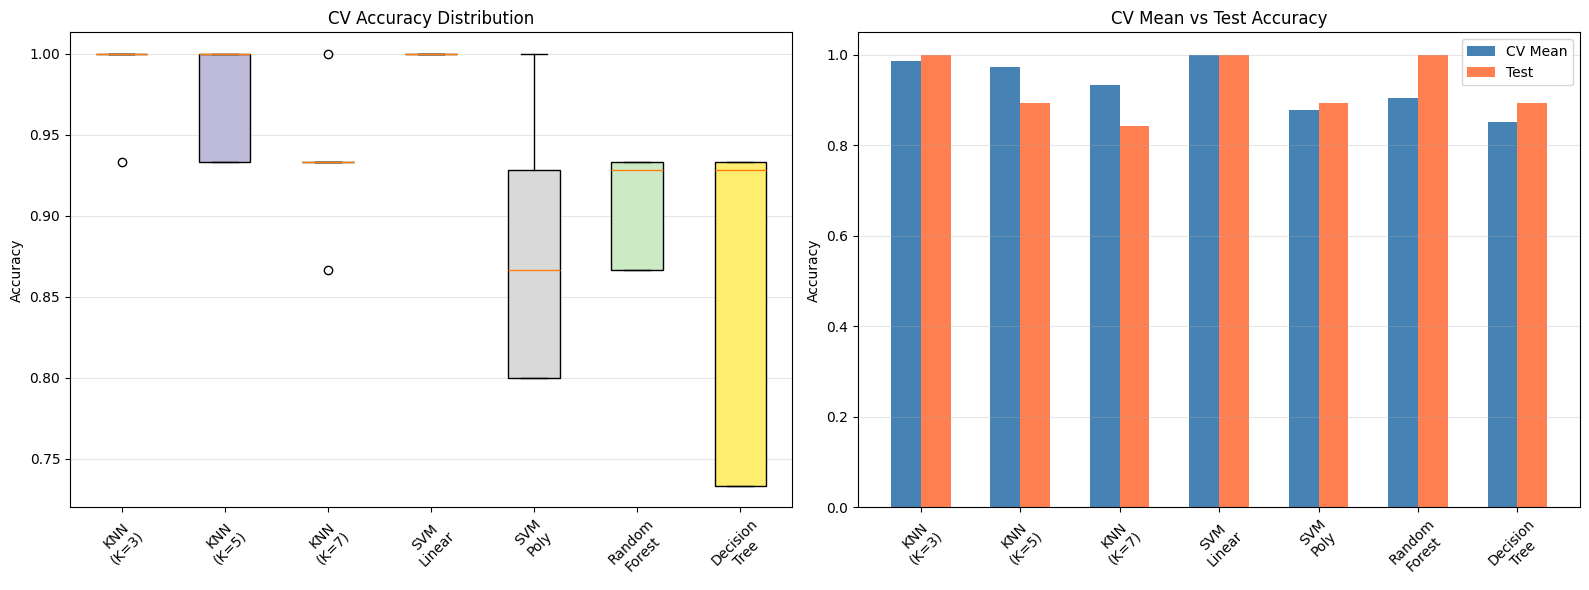

In [16]:
# Cell 6: Results Visualization
# -----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
bp = axes[0].boxplot([results[m]['cv'] for m in models],
                     labels=[m.replace(' ', '\n') for m in models],
                     patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
axes[0].set_title('CV Accuracy Distribution')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Bar chart
x = np.arange(len(models))
cv_means = [results[m]['cv'].mean() for m in models]
test_accs = [results[m]['test'] for m in models]
axes[1].bar(x - 0.15, cv_means, 0.3, label='CV Mean', color='steelblue')
axes[1].bar(x + 0.15, test_accs, 0.3, label='Test', color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels([m.replace(' ', '\n') for m in models], rotation=45)
axes[1].set_title('CV Mean vs Test Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Best Model: SVM Linear
CV Accuracy: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000

              precision    recall  f1-score   support

    Americas       1.00      1.00      1.00         5
Asia_Oceania       1.00      1.00      1.00         4
      Europe       1.00      1.00      1.00        10

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



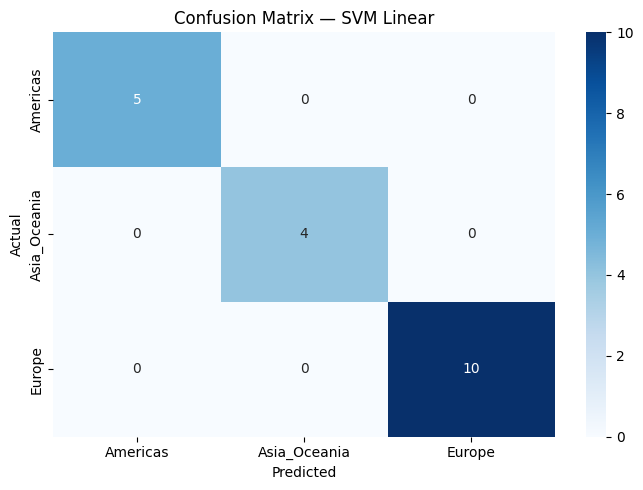

In [17]:
# Cell 7: Best Model — Detailed Report
# -----------------------------------------------------------

best = max(results, key=lambda k: results[k]['cv'].mean())
print(f"Best Model: {best}")
print(f"CV Accuracy: {results[best]['cv'].mean():.4f} (+/- {results[best]['cv'].std():.4f})")
print(f"Test Accuracy: {results[best]['test']:.4f}\n")

y_pred = models[best].predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix — {best}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

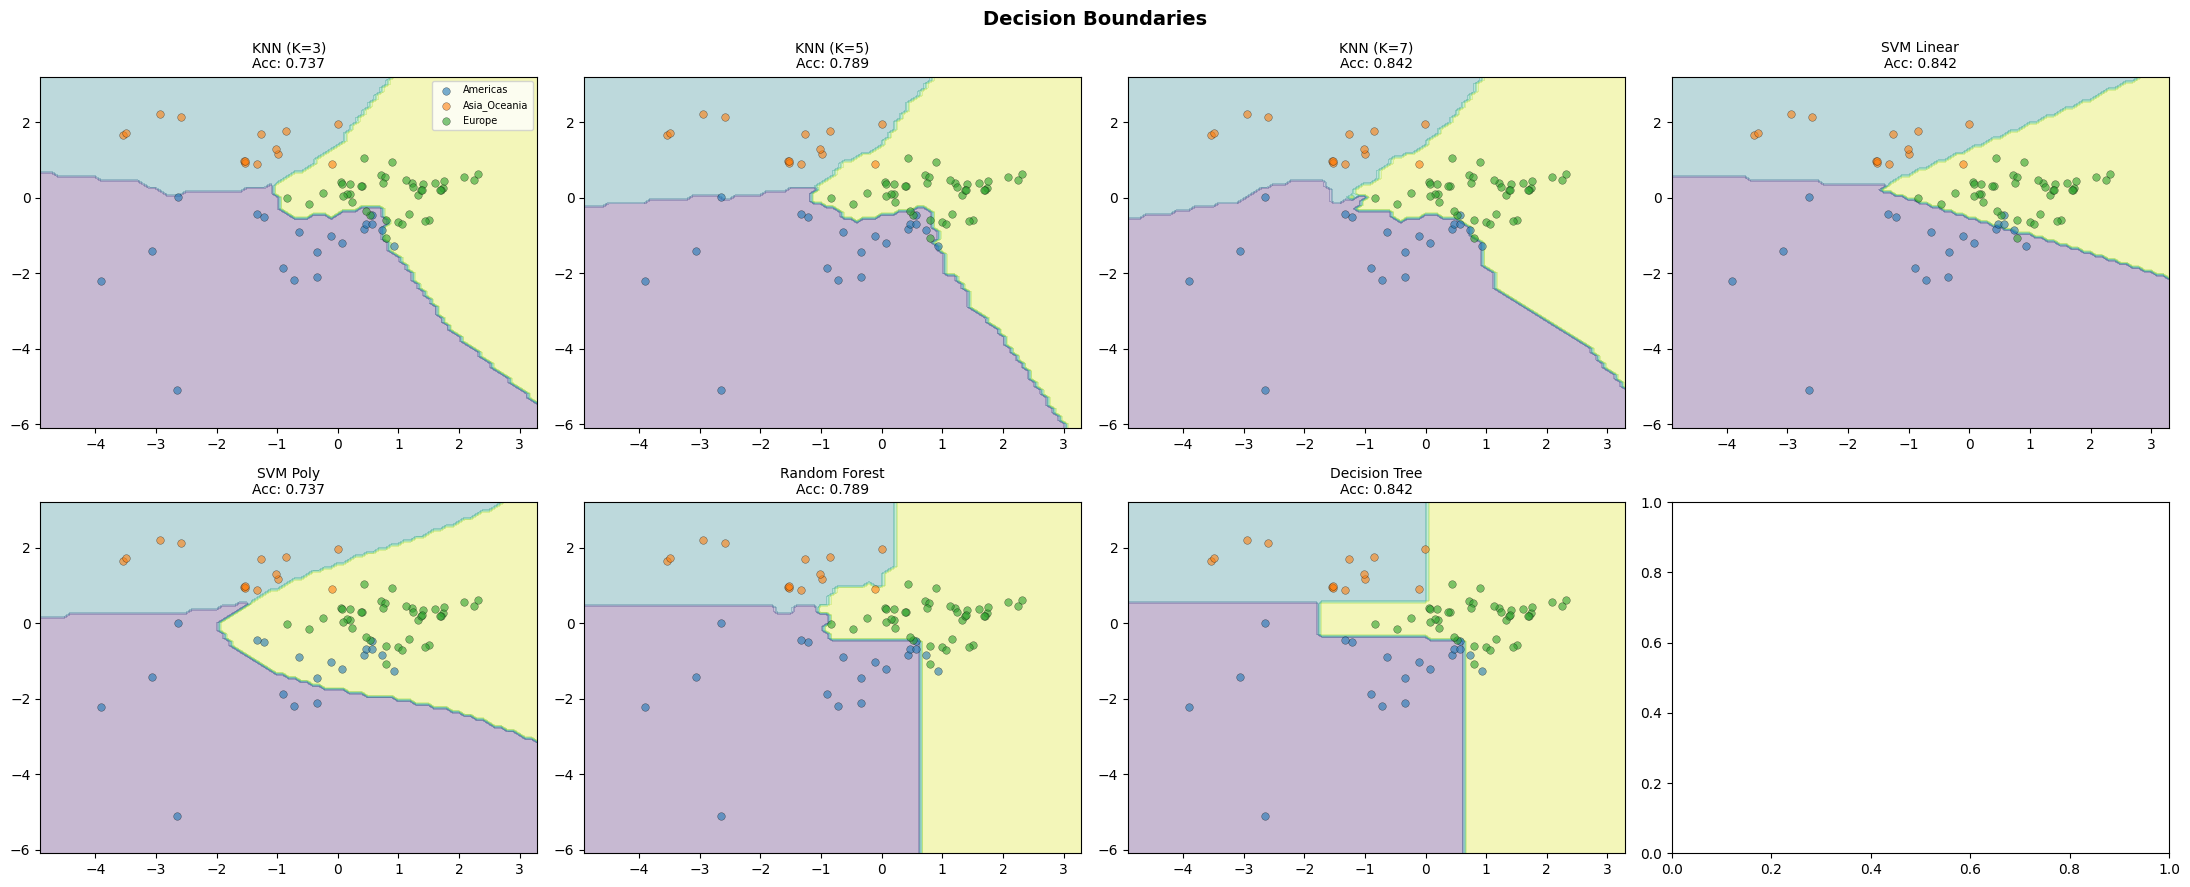

In [18]:
# Cell 8: Decision Boundaries (2D)
# -----------------------------------------------------------

X_2d = X_pca[:, :2]
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_2d, y, test_size=0.25, random_state=42, stratify=y)

h = 0.1
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

fig, axes = plt.subplots(2, 4, figsize=(22, 9))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    clf = model.__class__(**model.get_params())
    clf.fit(X_tr2, y_tr2)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    for i, region in enumerate(le.classes_):
        mask = y == i
        axes[idx].scatter(X_2d[mask, 0], X_2d[mask, 1], label=region, alpha=0.6, s=30, edgecolors='k', linewidth=0.3)

    acc = accuracy_score(y_te2, clf.predict(X_te2))
    axes[idx].set_title(f'{name}\nAcc: {acc:.3f}', fontsize=10)
    if idx == 0:
        axes[idx].legend(fontsize=7)

plt.suptitle('Decision Boundaries', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()